In [39]:
import pandas as pd
from datetime import datetime
import downloader as dl
import glob, os
# from fcmeans import FCM
# import hdbscan
import numpy as np
from numpy import arange, array, ones
from numpy.linalg import lstsq

In [16]:
clusterer = hdbscan.HDBSCAN()

NameError: name 'hdbscan' is not defined

In [40]:
resolution = 'minute'
multiplier = 1
tic = 'AAPL'
dir_ = os.path.join(dl.SAVE_DIR, f'{resolution}_{multiplier}')
path = os.path.join(dir_, f'{tic}_*')
files = glob.glob(path)

In [41]:
df = dl.load_dataset(tic, resolution=resolution)[tic]

In [98]:
max_error = 2
n = 480
data = df['close'][:n].reset_index(drop=True)

In [99]:
data = data.to_numpy()
data

array([0.3863, 0.3868, 0.3884, 0.3882, 0.3875, 0.3875, 0.387 , 0.3854,
       0.385 , 0.3836, 0.3832, 0.3831, 0.3834, 0.3825, 0.3825, 0.382 ,
       0.3822, 0.3822, 0.3831, 0.3834, 0.383 , 0.3825, 0.3822, 0.3818,
       0.382 , 0.3823, 0.3822, 0.3823, 0.3822, 0.3825, 0.382 , 0.3844,
       0.3843, 0.3845, 0.3836, 0.3827, 0.3832, 0.3832, 0.3832, 0.3825,
       0.3827, 0.3837, 0.3829, 0.3831, 0.3831, 0.3836, 0.3838, 0.3836,
       0.3832, 0.3831, 0.3831, 0.3827, 0.3825, 0.3822, 0.3825, 0.3831,
       0.3829, 0.3822, 0.3823, 0.3831, 0.3826, 0.3825, 0.3823, 0.3823,
       0.3831, 0.3822, 0.3829, 0.3829, 0.3831, 0.3831, 0.3831, 0.3832,
       0.3829, 0.3831, 0.3827, 0.3827, 0.3829, 0.3834, 0.3838, 0.3834,
       0.3829, 0.3829, 0.3825, 0.3825, 0.3834, 0.3829, 0.3831, 0.3834,
       0.3834, 0.3836, 0.3831, 0.3834, 0.3834, 0.3832, 0.3831, 0.3831,
       0.3831, 0.3829, 0.3831, 0.3831, 0.3831, 0.3827, 0.3823, 0.3823,
       0.3827, 0.3822, 0.382 , 0.3825, 0.3825, 0.3823, 0.382 , 0.382 ,
      

In [100]:
def leastsquareslinefit(sequence,seq_range):
    """Return the parameters and error for a least squares line fit of one segment of a sequence"""
    x = arange(seq_range[0],seq_range[1]+1)
    y = array(sequence[int(seq_range[0]):int(seq_range[1])+1])
    A = ones((len(x),2),float)
    A[:,0] = x
    (p,residuals,rank,s) = lstsq(A,y)
    try:
        error = residuals[0]
    except IndexError:
        error = 0.0
    return (p,error)

In [101]:
def regression(sequence, seq_range):
    """Return (x0,y0,x1,y1) of a line fit to a segment of a sequence using linear regression"""
    p, error = leastsquareslinefit(sequence,seq_range)
    y0 = p[0]*seq_range[0] + p[1]
    y1 = p[0]*seq_range[1] + p[1]
    return (seq_range[0],y0,seq_range[1],y1)

In [102]:
def sumsquared_error(sequence, segment):
    """Return the sum of squared errors for a least squares line fit of one segment of a sequence"""
    x0,y0,x1,y1 = segment
    p, error = leastsquareslinefit(sequence,(x0,x1))
    return error

In [103]:
def bottomupsegment(sequence, create_segment, compute_error, max_error):
    """
    Return a list of line segments that approximate the sequence.
    
    The list is computed using the bottom-up technique.
    
    Parameters
    ----------
    sequence : sequence to segment
    create_segment : a function of two arguments (sequence, sequence range) that returns a line segment that approximates the sequence data in the specified range
    compute_error: a function of two argments (sequence, segment) that returns the error from fitting the specified line segment to the sequence data
    max_error: the maximum allowable line segment fitting error
    
    """
    segments = [create_segment(sequence,seq_range) for seq_range in zip(range(len(sequence))[:-1],range(len(sequence))[1:])]
    mergesegments = [create_segment(sequence,(seg1[0],seg2[2])) for seg1,seg2 in zip(segments[:-1],segments[1:])]
    mergecosts = [compute_error(sequence,segment) for segment in mergesegments]

    while min(mergecosts) < max_error:
        idx = mergecosts.index(min(mergecosts))
        segments[idx] = mergesegments[idx]
        del segments[idx+1]

        if idx > 0:
            mergesegments[idx-1] = create_segment(sequence,(segments[idx-1][0],segments[idx][2]))
            mergecosts[idx-1] = compute_error(sequence,mergesegments[idx-1])

        if idx+1 < len(mergecosts):
            mergesegments[idx+1] = create_segment(sequence,(segments[idx][0],segments[idx+1][2]))
            mergecosts[idx+1] = compute_error(sequence,mergesegments[idx])

        del mergesegments[idx]
        del mergecosts[idx]

    return segments

In [104]:
segments = bottomupsegment(data, regression, sumsquared_error, max_error)
segments

<ipython-input-100-2c399b94fc2b>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = lstsq(A,y)


ValueError: min() arg is an empty sequence

In [105]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

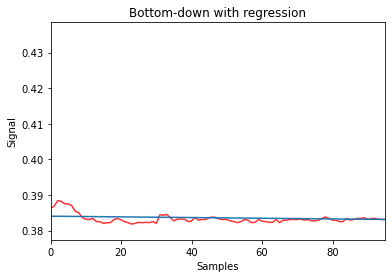

In [96]:
figure()
draw_plot(data,"Bottom-down with regression")
draw_segments(segments)

In [97]:
usl = df['high'] - df['close']
lsl = df['open'] - df['low']
body = np.absolute(df['close'] - df['open'])
color = df['close'] > df['open']

In [ ]:
usl = pd.DataFrame(usl)

In [ ]:
usl

In [ ]:
usl_r = clusterer.fit(usl)